## Local Coordination Game

$\alpha$ and $\beta$ can be considered the personal benefit, independent of others choices, that player i gets from choose a and b respectively. Unlike in the situation we studied in class, here the degree of the node does not drop out of the equation and there is not a uniform equation for a probabilistic best reply _irrespective_ of the degree of the node.

Instead the best reply of A is given when:

$$
P_A \geq \big( \frac{\beta - \alpha}{D_i} + b \big) \frac{1}{a + b}
$$

Where $P_A$ is the probability of a node starting A and $D_i$ is the degree of the node.

Similarly, the reason we could characterize nash equilibria by p-clusters in the simpler case was, where the best reply of A was given by $ P_A \geq \frac{b}{a + b}$, was that we could relate the p-cluster values to that static threshold. We no longer have this, now the threshold for each node is dependent on its degree, and p-clusters no longer suffice to characterize equilibria. To be more specific, with large enough $\alpha$, the p-percentage of a given node (the number of nodes of similar choice it is connected to) with small degree will be irrelevant, as the fixed $\alpha$ will dominate the decision-making process, which will only get moderated as the degree of the node grows. 


## Community Detection

a) The concept of _resolution limit_ is very nicely described in Barabasi, where he makes it very clear that the discrete nature of links limits our ability to detect communities below a certain size (relative to the total number of links in the network), because the expected number of links to a another small community will be less than one! 

b) Again, Barabasi provides a nice introduction to the GN and LFR benchmarks, where we randomly generate graphs by assigning nodes to communities (the "ground truth" we compare against) and then comparing in different ways the results of the community-detection algorithms. The LFR takes into account the distributional meta characteristics of many popular networks, which makes it seem better in many ways. I cannot help but notice, however, that just because the size of communities follows a power law distribution, does not mean that the way in which those communities are connected to each other is homogenous, as a single probability parameter would imply. Because of this I cannot help but think that using more complex random-graph generation models, such as those that allow for rich-get-richer characteristics, might have more heterogeneous communities that reflect more accurately those we see in real life. 

c) Scientific communities is a classic dataset, most likely popular because everyone using this dataset is also a part of it! For communities the most common is the collaboration graphs, instea do the directed citation version. However, there are also biological variants (protein interactions), and of course social networks! SNAP includes some with "ground-truth" communities including from friendster and livejournal. Also there are the "traditional" datasets such as the Karate Club and Florentine families. Additionally, Newman uses Amazon co-purchasing data for community detection!

In [0]:
!conda uninstall --yes networkx
!pip install --upgrade git+git://github.com/networkx/networkx.git#egg=networkx

In [148]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from itertools import islice

In [41]:
def network_from_df(path = "data/high-energy-trimmed.txt"):
    df = pd.read_csv(path)
    G = nx.DiGraph()
    df = pd.read_csv(path, sep="\t")
    nodes = df.iloc[:, 1].unique().tolist()
    edges = [(f[0], f[1]) for f in df.as_matrix()]
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G


get_top_hubs = lambda hits: get_top_nodes(hits[0])
get_top_auths = lambda hits: get_top_nodes(hits[1])

def get_top_nodes(d, n = 20):
    return map(lambda x: x[0],
               sorted(d.items(), key=lambda x: x[1]))[0:n]

def erdos_degrees(n, p):
    graph = nx.erdos_renyi_graph(n, p)
    degrees = list(d[1] for d in graph.degree())
    return pd.DataFrame({ p: degrees})

## Erdos Renyi Graphs

The plots of the degree distributions follow more-or-less as we expect, seeming to come from the same distribution but becoming more regular as we increase the size of the graph. 

All large graphs with degree probability of more than 0.01 only had one component, so we look at the entire graph! Reducing the probability allows us to find multiple components, but even at 0.001, there is one large component and a bunch of 1-node components!

In [9]:
erdos_graphs_5k = [nx.erdos_renyi_graph(1000, p) for p in [0.01, 0.1, 0.25, 0.6, 0.9]]

In [8]:
[nx.number_connected_components(G) for G in erdos_graphs_5k]

[1, 1, 1, 1, 1]

In [10]:
[nx.average_shortest_path_length(G) for G in erdos_graphs_5k]

[3.2634514514514517,
 1.899925925925926,
 1.7502342342342343,
 1.401107107107107,
 1.0998178178178177]

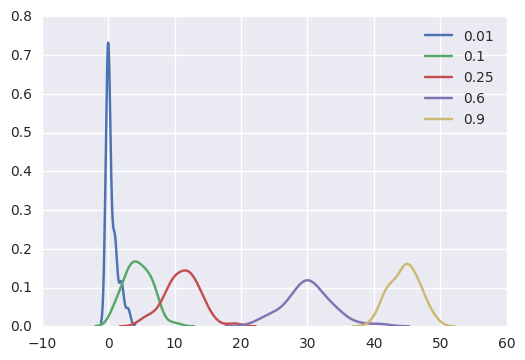

In [78]:
p = [sns.kdeplot(erdos_degrees(50, p)[p]) for p in [0.01, 0.1, 0.25, 0.6, 0.9]]
plt.show()

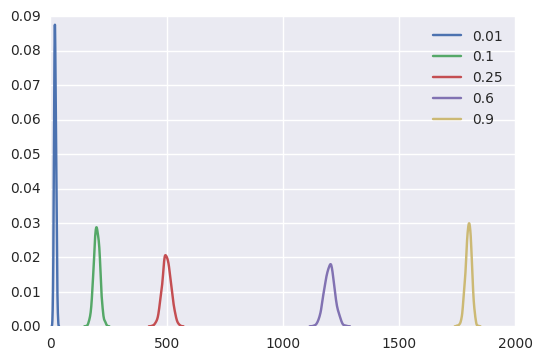

In [79]:
p = [sns.kdeplot(erdos_degrees(2000, p)[p]) for p in [0.01, 0.1, 0.25, 0.6, 0.9]]
plt.show()

### Looking at the tail

We can see that looking closely at the tail of our degree distribution, it doesn't actually follow a power law very well, the tails decaying much faster than would be expected given a power law distribution!

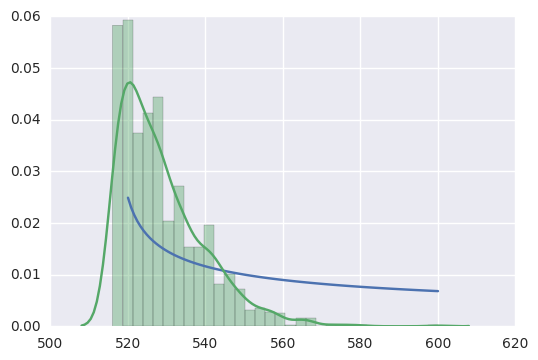

In [80]:
from scipy.stats import powerlaw
from numpy import linspace

def generate_tail(n,p):
    degrees = erdos_degrees(n, p)
    thresh = np.percentile(degrees, 75)    
    return degrees[degrees[p] > thresh]

x = linspace(520,600,100)
t = generate_tail(5000,0.1)
p = powerlaw.fit(t)

power = plt.plot(x, pd.DataFrame({'Fitted Power Law': powerlaw.pdf(x, p[0], p[1], p[2])}))
data = sns.distplot(t)
plt.show()

## SNAP High-Energy Physics Collaborations

a) We can see that through each different centrality measure, we get different rankings. Because this particular network was recorded with directed edges but is symmetric (in reality, undirected), the hubs and authorities measures are exactly the same. Interestingly, the eigenvector centrality is very similar, which makes some sense when you consider the iterative nature of the HTIS algorithm and the relationship to the eigenvector centrality. 

In [10]:
g = network_from_df()
hits = nx.hits_scipy(g)
pagerank = nx.pagerank_scipy(g)# default .85
eigen = nx.eigenvector_centrality(g)
degree = nx.degree_centrality(g)

In [11]:
pd.DataFrame({
    'degree': get_top_nodes(degree),
    'eigen': get_top_nodes(eigen),
    'pagerank': get_top_nodes(pagerank),
    'hubs': get_top_hubs(hits),
    'authorities': get_top_auths(hits)
})

    authorities  degree  eigen   hubs  pagerank
0            69       1     69     69      8264
1         65674      11  65674  65674     50553
2         65883      29  65883  65883      6012
3           417   32801    417    417      2983
4           427      69    427    427     47634
5         65989   32894  65989  65989     59316
6         33311   32896  33311  33311      2886
7         66187   65669  66187  66187     45666
8         71132     134   5596  71132      8098
9           943   65674    943    943     55691
10         1121     146   1121   1121     81047
11        33936     218  33936  33936     38389
12         1296     228  16588   1296     35935
13        67059   65776   1296  67059     73178
14        34629   65786  66883  34629     49085
15         1873     254  75334   1873     83774
16        67548   65793  67059  67548      8410
17        67569   65796  34629  67569     19421
18         5813   33033   1873   5813     26105
19        34950     335  67548  34950   

### Macro Properties of SNAP Dataset

We see that there are a number of separate connected components in this network and we can look at the degree distribution, which looks like it does have a very long tail, indicative of a power-law distribution we might expect from theory! What's interesting is the final mode around 240, where you have some group of individuals who collaborate with ~240, and there are a few that seem to cluster around that number! Could very well be random, but curious nonetheless. 

In [0]:
undirected_collab = g.to_undirected()

In [39]:
nx.number_connected_components(undirected_collab)

278

19.740339773484344

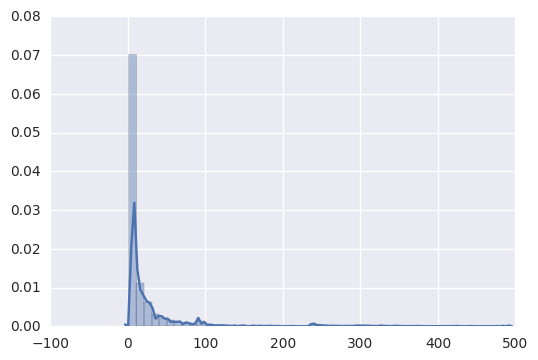

In [37]:
degrees = list((j for i,j in (nx.degree(undirected_collab))))
sns.distplot(degrees)
np.mean(degrees)

## Communities in Famous Data Sets

### Girvan-Newman and Multiple Near-Maximums

Looking first at the girvan newman method, we measure the modularity of every set and use that to determine an optimal "cut-point". The ground-truth of this network only gives us information about 2 communities, whereas this method provides us with 5, however this also corresponds with the theory that maximum modularity is a function with a large plateu around the maximum, with many possible splits being very close in modularity. We exame the modularity of all the G-N splits to see this in effect. 

In [159]:
karate = nx.karate_club_graph()

In [175]:
class Girvan():
    def __init__(self, g, mx = 10):
        newman_coms = list(islice(nx.girvan_newman(g), 0, mx))
        modularity = [nx.modularity(g, c) for c in newman_coms]
        i = np.argmax(modularity)
        self.best = newman_coms[i]
        self.rounds = newman_coms
        self.modularities = modularity

karate_girvan = Girvan(karate)
karate_girvan.best

({0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
 {2, 24, 25, 27, 28, 31},
 {4, 5, 6, 10, 16},
 {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
 {9})

In [176]:
karate_girvan.modularities

[0.35996055226824225,
 0.348783694937539,
 0.3632478632478615,
 0.4012984878369487,
 0.39250493096646893,
 0.37623274161735665,
 0.358316896778435,
 0.34171597633136075,
 0.33284023668639046,
 0.3159105851413543]

### Comparing Girvan-Newman to Spectral Method

One interesting comparrison is to look at the first split of Girvan-Newman, which in this instance creates two communities, and compare it to the Spectral Method using the largest positive eigenvector, the sign of which should give a maximum modularity

In [227]:
def get_eigen_split(g, directed = False):
    m = nx.modularity_matrix(g) if not directed else nx.directed_modularity_matrix(g)
    vals, vecs = np.linalg.eig(m)    
    v = vecs[:, np.argmax(vals)]
    nodes = list(g.nodes())
    lists = [[i[0] for i in n] 
           for n in [np.argwhere(v > 0), np.argwhere(v < 0), np.argwhere(v == 0.0)]]
    a,b,c = [set([nodes[i] for i in n]) for n in lists]
    return a,b,c

karate_eigen_split = get_eigen_split(karate)
karate_eigen_split

({8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
 {0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
 set())

In [229]:
karate_girvan.rounds[0]

({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
 {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})

In [230]:
# We see here that the eigen value method returns, in one iteration, a higher modularity, despite only changing the group of one single individual. 

nx.modularity(karate, karate_girvan.rounds[0]), nx.modularity(karate, karate_eigen_split)

(0.35996055226824225, 0.371466140696909)

### School Children

For this second dataset, I wanted to examine another small dataset that I could visually inspect, and wanted to use one that I already had access to and needed to work with. I know it's not technically a famous data set, but it was a useful analysis for me and I wanted to share! See comments for comparrisons to the previous data set. 

In [145]:
def network_group(g, directed = True, folder = 'educatalyst/Data/Raw/1612_jesuites'):
    path = os.path.join(folder, g+'_1612_q6.csv')
    df = pd.read_csv(path)
    nodes = df['User Id'].unique()
    friends = [[int(n) for n in i if not np.isnan(n)] for i in df.iloc[:, 4:9].as_matrix()]
    edges = [[(n,f) for f in fs] for n,fs in zip(nodes, friends)]
    edges = [e for i in edges for e in i]
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

In [234]:
# Again we see a very FLAT plateau around the maximum modularity, with all of the
# first 10 splits giving fairly similar results!
ij = network_group('ij')
ij_girvan = Girvan(ij)
ij_girvan.modularities

[0.548799999999999,
 0.5459999999999994,
 0.5431999999999992,
 0.555975,
 0.5412500000000001,
 0.5449999999999999,
 0.5376499999999999,
 0.5336999999999997,
 0.5275749999999998,
 0.5201999999999999]

In [219]:
ij_girvan.rounds[0]

({291,
  293,
  295,
  296,
  297,
  298,
  299,
  300,
  301,
  302,
  304,
  306,
  307,
  308,
  309,
  310,
  311,
  312,
  313,
  316,
  317},
 {292, 294, 303, 305, 314, 315},
 {318,
  319,
  320,
  321,
  322,
  323,
  324,
  325,
  326,
  327,
  328,
  329,
  330,
  331,
  332,
  333,
  334,
  335,
  336,
  337,
  338,
  339,
  340,
  341,
  342})

In [232]:
ij_eigen_split = get_eigen_split(ij, True)
ij_eigen_split

({291,
  293,
  294,
  295,
  296,
  297,
  298,
  299,
  300,
  301,
  302,
  303,
  304,
  305,
  307,
  309,
  310,
  311,
  312,
  313,
  314,
  315,
  317},
 {318,
  320,
  321,
  323,
  324,
  326,
  327,
  328,
  329,
  330,
  333,
  335,
  336,
  337,
  339,
  340,
  341,
  342},
 {292, 306, 308, 316, 319, 322, 325, 331, 332, 334, 338})

In [233]:
# Interesting to see that when there are nodes that are not easy to classify into any group, the eigenvector is equal to 0, and the method now fails to maximize modularity compared to the first round of Girvan Newman, in this instance!
nx.modularity(ij, ij_girvan.rounds[0]), nx.modularity(ij, ij_eigen_split)

(0.548799999999999, 0.3753999999999993)